In [1]:
import pandas as pd
from tensorflow import keras, constant
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans

2023-03-16 22:02:50.423942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
results_file_name = '../data/pcs_worldtour_results.csv'
results = pd.read_csv(results_file_name, index_col = 0)
results['points'] = results.groupby('race_url').pcs_points.transform(lambda x: x / x.max())
results['one_day'] = results['race_url'].str.count('/') == 2
results = results.query('one_day')

races = pd.read_csv('../data/pcs_worldtour_races.csv')
riders = pd.read_csv('../data/pcs_worldtour_riders.csv', index_col = 0)
results = pd.merge(results, races)
results = pd.merge(results, riders)
results

,rider_url,team_url,rank,status,age,time,pcs_points,uci_points,race_url,points,one_day,race_name,year,stage_race,rider_name,nationality
0,arnaud-demare,fdj-2016,1.0,DF,24,6:54:45,275,500.0,race/milano-sanremo/2016,1.000000,True,milano-sanremo,2016,False,DÉMARE Arnaud,FR
1,arnaud-demare,fdj-2016,5.0,DF,24,5:55:23,80,225.0,race/gent-wevelgem/2016,0.355556,True,gent-wevelgem,2016,False,DÉMARE Arnaud,FR
2,arnaud-demare,fdj-2016,NaN,DNF,24,NaN,0,0.0,race/ronde-van-vlaanderen/2016,0.000000,True,ronde-van-vlaanderen,2016,False,DÉMARE Arnaud,FR
3,arnaud-demare,fdj-2016,34.0,DF,24,4:54:45,5,8.0,race/cyclassics-hamburg/2016,0.022222,True,cyclassics-hamburg,2016,False,DÉMARE Arnaud,FR
4,arnaud-demare,fdj-2016,NaN,DNF,25,NaN,0,0.0,race/bretagne-classic/2016,0.000000,True,bretagne-classic,2016,False,DÉMARE Arnaud,FR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20153,santiago-umba,drone-hopper-androni-giocattoli-2022,88.0,DF,19,6:39:45,5,0.0,race/il-lombardia/2022,0.018182,True,il-lombardia,2022,False,UMBA Santiago,CO
20154,natnael-tesfatsion,drone-hopper-androni-giocattoli-2022,NaN,DNF,23,NaN,0,0.0,race/il-lombardia/2022,0.000000,True,il-lombardia,2022,False,TESFATSION Natnael,ER
20155,sean-quinn,ef-education-easypost-2022,NaN,DNF,22,NaN,0,0.0,race/il-lombardia/2022,0.000000,True,il-lombardia,2022,False,QUINN Sean,US
20156,sergio-martin,caja-rural-seguros-rga-2022,NaN,DNF,25,NaN,0,0.0,race/il-lombardia/2022,0.000000,True,il-lombardia,2022,False,MARTÍN Sergio Roman,ES


In [5]:
model = keras.models.load_model('../models/pcs_worldtour_oneday_direct_embeddings')
results['pred'] = model.predict([results.rider_name, results.race_name]).round(4)
results.sort_values('pred', ascending = False).head(15)[['rider_name', 'race_name', 'year', 'rank', 'points', 'pred']]

630/630 [==============================] - 1s 886us/step


,rider_name,race_name,year,rank,points,pred
18173,EVENEPOEL Remco,san-sebastian,2022,1.0,1.000000,1.0044
18166,EVENEPOEL Remco,san-sebastian,2019,1.0,1.000000,1.0044
4774,ARNDT Nikias,great-ocean-race,2017,1.0,1.000000,0.8349
16326,VAN AERT Wout,bretagne-classic,2022,1.0,1.000000,0.8129
17976,VAN DER POEL Mathieu,ronde-van-vlaanderen,2021,2.0,0.727273,0.8094
17970,VAN DER POEL Mathieu,ronde-van-vlaanderen,2020,1.0,1.000000,0.8094
17980,VAN DER POEL Mathieu,ronde-van-vlaanderen,2022,1.0,1.000000,0.8094
17963,VAN DER POEL Mathieu,ronde-van-vlaanderen,2019,4.0,0.436364,0.8094
12611,GROENEWEGEN Dylan,oxyclean-classic-brugge-de-panne,2019,1.0,1.000000,0.7941
12614,GROENEWEGEN Dylan,oxyclean-classic-brugge-de-panne,2022,2.0,0.666667,0.7941


In [6]:
rider_dict = {i: v for i, v in enumerate(model.get_layer('rider_name_to_int').get_vocabulary())} 
all_rider_names = np.array(list(rider_dict.values())[1:])

rider_encoder = keras.Model(model.input[0], model.get_layer('rider_vector').output)

def rider_name_to_vector(rider_name):
    if not isinstance(rider_name, list):
        rider_name = [rider_name]
    return rider_encoder(constant(rider_name))
    
rider_name_to_vector('EVENEPOEL Remco'), rider_name_to_vector(['EVENEPOEL Remco', 'VAN Aert'])

(<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[-0.62507236, -0.21986185, -0.45205355,  0.6254721 ,  0.20994172,
         -0.13009325, -0.33821023,  0.23531958,  0.24564373, -0.17589954]],
       dtype=float32)>,
 <tf.Tensor: shape=(2, 10), dtype=float32, numpy=
 array([[-0.62507236, -0.21986185, -0.45205355,  0.6254721 ,  0.20994172,
         -0.13009325, -0.33821023,  0.23531958,  0.24564373, -0.17589954],
        [ 0.03581891,  0.01626286, -0.01412892,  0.04499895, -0.04219389,
          0.01523323,  0.04704999, -0.03320879,  0.00237893,  0.01307596]],
       dtype=float32)>)

## Similar Riders

In [7]:
rider_nn = NearestNeighbors(n_neighbors = 2)
rider_nn.fit(rider_encoder(all_rider_names).numpy())

def rider_int_to_name(rider_int):
    return rider_dict[rider_int]
    
def get_nearest_rider(rider_name = 'EVENEPOEL Remco'):
    embedding = rider_name_to_vector(rider_name)
    distances, indices = rider_nn.kneighbors(embedding)
    return rider_int_to_name(indices[0][1] + 1)

riders_to_check = [
    'EVENEPOEL Remco',
    'POGAČAR Tadej',
    'VAN AERT Wout',
    'VAN DER POEL Mathieu',
    'SAGAN Peter',
    'ALAPHILIPPE Julian',
    'BENNETT Sam',
    'NIBALI Vincenzo',
    'GILBERT Philippe'
]

{r: get_nearest_rider(r) for r in riders_to_check}

{'EVENEPOEL Remco': 'RODRÍGUEZ Joaquim',
 'POGAČAR Tadej': 'PINOT Thibaut',
 'VAN AERT Wout': 'NAESEN Oliver',
 'VAN DER POEL Mathieu': 'CANCELLARA Fabian',
 'SAGAN Peter': 'GIRMAY Biniam',
 'ALAPHILIPPE Julian': 'VALVERDE Alejandro',
 'BENNETT Sam': 'PHILIPSEN Jasper',
 'NIBALI Vincenzo': 'URÁN Rigoberto',
 'GILBERT Philippe': 'VAN BAARLE Dylan'}

## Race Prediction

In [8]:
preds = model.predict(
    [all_rider_names,
     np.array(['paris-roubaix'] * len(all_rider_names))])
pd.DataFrame({'rider': all_rider_names, 'pred': preds.flatten()}).sort_values('pred', ascending = False).head(15)

49/49 [==============================] - 0s 1ms/step


,rider,pred
1148,VAN DER POEL Mathieu,0.379775
359,HAYMAN Mathew,0.360545
4,VAN AVERMAET Greg,0.338408
58,MATTHEWS Michael,0.331758
1242,VERMEERSCH Florian,0.327866
11,SAGAN Peter,0.326582
54,BOONEN Tom,0.323533
8,COLBRELLI Sonny,0.307826
433,GILBERT Philippe,0.288705
23,VANMARCKE Sep,0.287994


## Similar Races

In [9]:
race_dict = {i: v for i, v in enumerate(model.get_layer('race_name_to_int').get_vocabulary())}

race_similarities = pairwise_distances(model.get_layer('race_encoder').get_weights()[0])
race_similarities = (
    pd.DataFrame(race_similarities)
    .stack()
    .reset_index()
    .rename(columns = {'level_0': 'race_1', 'level_1': 'race_2', 0: 'similarity'})
    .query('race_1 < race_2')
    .assign(
        race_1 = lambda x: x.race_1.replace(race_dict),
        race_2 = lambda x: x.race_2.replace(race_dict)
    )
    .query('race_1 != "[UNK]" and race_2 != "[UNK]"')
)
race_similarities.sort_values('similarity', ascending = True).head(10)

,race_1,race_2,similarity
282,ride-london-classic,eschborn-frankfurt,0.486484
53,gent-wevelgem,gp-quebec,0.610980
76,ronde-van-vlaanderen,gp-montreal,0.674315
24,milano-sanremo,gent-wevelgem,0.694923
50,gent-wevelgem,omloop-het-nieuwsblad,0.734315
80,ronde-van-vlaanderen,amstel-gold-race,0.738469
77,ronde-van-vlaanderen,e3-harelbeke,0.759207
73,ronde-van-vlaanderen,dwars-door-vlaanderen,0.766796
140,omloop-het-nieuwsblad,paris-roubaix,0.770224
327,amstel-gold-race,strade-bianche,0.793467


## Clustering Riders and Plotting PCA

In [33]:
# Cluster riders
rider_embeddings = rider_encoder(all_rider_names).numpy()
kmeans = KMeans(n_clusters = 5, random_state = 0).fit(rider_embeddings)

# Perform PCA on embeddings
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
pca_features = pca.fit_transform(rider_embeddings)

# Combine results
pca_df = pd.DataFrame(pca_features)
pca_df['rider'] = all_rider_names
pca_df['cluster'] = kmeans.labels_
pca_df

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,0,1,2,3,4,rider,cluster
0,0.102667,0.226780,0.127007,0.121413,-0.138516,DÉMARE Arnaud,3
1,-0.001792,0.071277,0.033952,-0.017386,-0.064298,SWIFT Ben,0
2,0.123210,0.080417,0.035965,0.100485,-0.127835,ROELANDTS Jürgen,1
3,0.161298,0.259312,-0.102067,-0.095064,-0.009500,BOUHANNI Nacer,3
4,0.584798,-0.054788,0.038174,0.042928,0.254203,VAN AVERMAET Greg,2
...,...,...,...,...,...,...,...
1557,0.008887,0.003151,0.028424,0.010390,-0.006363,UMBA Santiago,0
1558,0.015305,0.013363,-0.012224,0.030630,0.014494,TESFATSION Natnael,0
1559,0.011204,0.021642,-0.040621,-0.032477,-0.049452,QUINN Sean,0
1560,0.005681,0.011428,-0.074108,0.019139,-0.024747,MARTÍN Sergio Roman,0


In [34]:
pca_df.cluster.value_counts()

0    1301
1     180
4      36
3      29
2      16
Name: cluster, dtype: int64

In [35]:
pca_df.groupby('cluster').rider.unique()

cluster
0    [SWIFT Ben, POZZATO Filippo, MONTAGUTI Matteo,...
1    [ROELANDTS Jürgen, HAUSSLER Heinrich, COLBRELL...
2    [VAN AVERMAET Greg, SAGAN Peter, VALVERDE Alej...
3    [DÉMARE Arnaud, BOUHANNI Nacer, TRENTIN Matteo...
4    [KRISTOFF Alexander, VANMARCKE Sep, NIZZOLO Gi...
Name: rider, dtype: object

In [40]:
pca_df.sort_values(0)

,0,1,2,3,4,rider,cluster
190,-0.310916,0.035416,0.493906,0.503348,-0.291935,ARNDT Nikias,0
125,-0.207210,-0.006820,-0.012568,-0.359477,-0.031540,LIGTHART Pim,4
461,-0.181157,-0.053266,-0.061629,-0.248058,0.008983,BOLE Grega,0
633,-0.159012,0.636743,-0.326673,0.131114,0.000915,GROENEWEGEN Dylan,3
868,-0.157860,-0.046529,0.048920,0.030257,-0.029350,SAGIV Guy,0
...,...,...,...,...,...,...,...
30,0.578396,0.375968,0.044065,0.186382,0.185033,CANCELLARA Fabian,2
1169,0.582187,0.182759,-0.264000,0.225896,-0.476766,EVENEPOEL Remco,3
4,0.584798,-0.054788,0.038174,0.042928,0.254203,VAN AVERMAET Greg,2
970,0.885737,0.167176,-0.113625,-0.116343,-0.445782,VAN AERT Wout,2


In [41]:
pca_df.sort_values(1)

,0,1,2,3,4,rider,cluster
14,0.469431,-0.505699,-0.187646,0.018391,-0.027860,VALVERDE Alejandro,2
817,0.049160,-0.489045,-0.103376,0.164352,-0.358281,ROGLIČ Primož,1
693,0.134836,-0.444835,0.122060,-0.189027,-0.107173,CHAVES Esteban,1
815,0.170474,-0.427211,-0.019218,-0.146370,-0.218922,PINOT Thibaut,1
995,0.252805,-0.379867,-0.137334,0.002626,0.012988,VLASOV Aleksandr,1
...,...,...,...,...,...,...,...
1090,-0.146622,0.531525,0.088655,-0.384692,-0.078573,PHILIPSEN Jasper,4
83,0.059516,0.611369,0.464854,-0.092866,-0.431373,VIVIANI Elia,4
633,-0.159012,0.636743,-0.326673,0.131114,0.000915,GROENEWEGEN Dylan,3
1302,0.303993,0.642296,-0.203647,-0.163886,0.100339,MERLIER Tim,3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


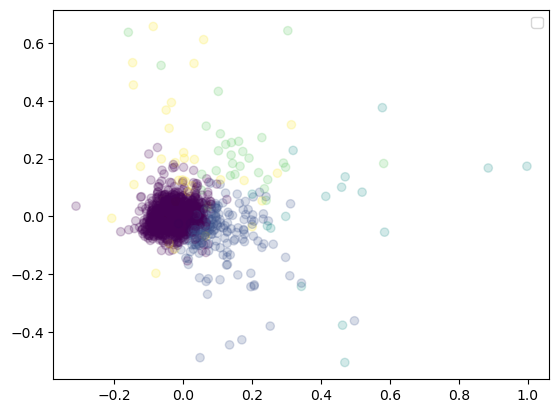

In [42]:
import matplotlib.pyplot as plt

plt.scatter(pca_df[0], pca_df[1], alpha = 0.2, c = pca_df['cluster'])
plt.legend()
plt.show()

In [48]:
import plotly.express as px
fig = px.scatter(pca_df, x = 0, y = 1, color = 'cluster', hover_data = ['rider'])
fig.show()